In [1]:
import numpy as np
import sncosmo
from astropy.table import Table
from matplotlib import pyplot as plt

import sys; sys.path.insert(0, '../')
from data_access import sdss


## Check filter transmission curves

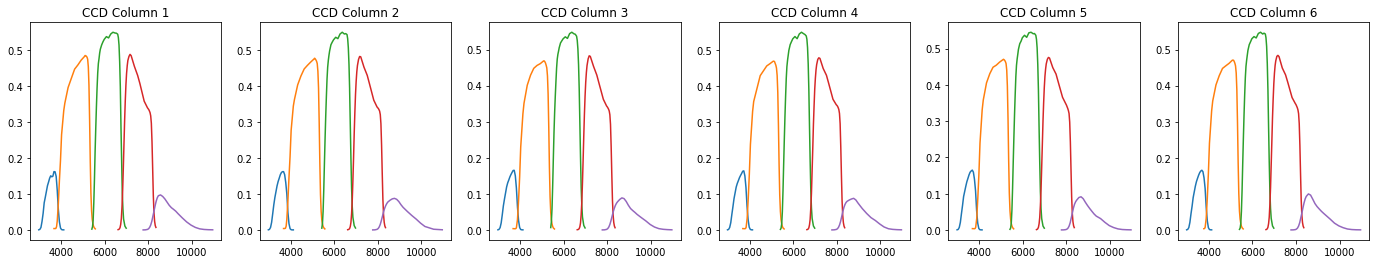

In [2]:
fig, axes = plt.subplots(1, 6, figsize=(24, 4))
for i, axis in enumerate(axes):
    for band in 'ugriz':
        band = sncosmo.get_bandpass('doi_2010_{}{}'.format(band, i + 1))
        axis.plot(band.wave, band.trans)
        axis.set_title('CCD Column {}'.format(i + 1))


## Get outlier data points

In [3]:
f_path = '/Users/daniel/Github/SDSS-Classification/data_access/sdss/data/SDSS_dataRelease-snana/SDSS_allCandidates+BOSS/SDSS_allCandidates+BOSS.IGNORE'

outliers = dict()
with open(f_path) as ofile:
    for line in ofile.readlines():
        if line.startswith('IGNORE:'):
            line_list = line.split()
            cid, mjd, band = line_list[1], line_list[2], line_list[3]
            if cid not in outliers:
                outliers[int(cid)] = dict(u=[], g=[], r=[], i=[], z=[])
            
            outliers[int(cid)][band].append(float(mjd))

outliers

{1032: {'u': [], 'g': [], 'r': [], 'i': [53668.387], 'z': []},
 1371: {'u': [], 'g': [], 'r': [53648.297], 'i': [], 'z': []},
 2031: {'u': [], 'g': [], 'r': [53657.207], 'i': [], 'z': []},
 2246: {'u': [], 'g': [53704.355], 'r': [], 'i': [], 'z': []},
 2372: {'u': [], 'g': [], 'r': [], 'i': [53693.348], 'z': []},
 2943: {'u': [], 'g': [], 'r': [], 'i': [53685.285], 'z': []},
 3377: {'u': [], 'g': [], 'r': [], 'i': [53687.441], 'z': []},
 3451: {'u': [], 'g': [], 'r': [], 'i': [53626.219], 'z': []},
 4241: {'u': [], 'g': [53699.289], 'r': [], 'i': [], 'z': []},
 5391: {'u': [], 'g': [53700.379], 'r': [], 'i': [], 'z': []},
 6127: {'u': [], 'g': [53698.164], 'r': [], 'i': [], 'z': []},
 6773: {'u': [], 'g': [], 'r': [], 'i': [53693.074], 'z': []},
 6699: {'u': [], 'g': [], 'r': [], 'i': [53703.129], 'z': []},
 7947: {'u': [], 'g': [], 'r': [], 'i': [53693.102], 'z': []},
 8495: {'u': [], 'g': [], 'r': [], 'i': [53671.254], 'z': []},
 9045: {'u': [], 'g': [53668.223], 'r': [], 'i': [], 'z

## Get SDSS published table of spectroscopically confirmed SNIa

In [4]:
spec_confirmed_sn = sdss.master_table[sdss.master_table['Classification'] == 'zSNIa']
spec_confirmed_sn.show_in_notebook(display_length=10)


idx,CID,RA,DEC,Nsearchepoch,IAUName,Classification,Peakrmag,MJDatPeakrmag,NepochSNR5,nSNspec,nGALspec,zspecHelio,zspecerrHelio,zCMB,zerrCMB,x0SALT2zspec,x0errSALT2zspec,x1SALT2zspec,x1errSALT2zspec,cSALT2zspec,cerrSALT2zspec,PeakMJDSALT2zspec,PeakMJDderrSALT2zspec,muSALT2zspec,muerrSALT2zspec,fitprobSALT2zspec,chi2SALT2zspec,ndofSALT2zspec,deltaMLCS2k2zspec,deltaerrMLCS2k2zspec,avMLCS2k2zspec,averrMLCS2k2zspec,PeakMJDMLCS2k2zspec,PeakMJDerrMLCS2k2zspec,muMLCS2k2zspec,muerrMLCS2k2zspec,fitprobMLCS2k2zspec,chi2MLCS2k2zspec,ndofMLCS2k2zspec,PIaPSNIDzspec,logprobIaPSNIDzspec,lcqualityIaPSNIDzspec,PIbcPSNIDzspec,logprobIbcPSNIDzspec,lcqualityIbcPSNIDzspec,PIIPSNIDzspec,logprobIIPSNIDzspec,lcqualityIIPSNIDzspec,NnnPSNIDzspec,PnnIaPSNIDzspec,PnnIbcPSNIDzspec,PnnIIPSNIDzspec,zPSNIDzspec,zerrPSNIDzspec,dm15PSNIDzspec,dm15errPSNIDzspec,avPSNIDzspec,averrPSNIDzspec,PeakMJDPSNIDzspec,PeakMJDerrPSNIDzspec,SNIbctypePSNIDzspec,SNIItypePSNIDzspec,x0SALT2flat,x0errSALT2flat,x1SALT2flat,x1errSALT2flat,cSALT2flat,cerrSALT2flat,PeakMJDSALT2flat,PeakMJDerrSALT2flat,zphotSALT2flat,zphoterrSALT2flat,fitprobSALT2flat,chi2SALT2flat,ndofSALT2flat,PIaPSNIDflat,logprobIaPSNIDflat,lcqualityIaPSNIDflat,PIbcPSNIDflat,logprobIbcPSNIDflat,lcqualityIbcPSNIDflat,PIIPSNIDflat,logprobIIPSNIDflat,lcqualityIIPSNIDflat,NnnPSNIDflat,PnnIaPSNIDflat,PnnIbcPSNIDflat,PnnIIPSNIDflat,zPSNIDflat,zerrPSNIDflat,dm15PSNIDflat,dm15errPSNIDflat,avPSNIDflat,averrPSNIDflat,PeakMJDPSNIDflat,PeakMJDerrPSNIDflat,SNIbctypePSNIDflat,SNIItypePSNIDflat,objIDHost,RAhost,DEChost,separationhost,DLRhost,zphothost,zphoterrhost,zphotRFhost,zphotRFerrhost,dereduhost,erruhost,deredghost,errghost,deredrhost,errrhost,deredihost,errihost,deredzhost,errzhost,logMassFSPS,logMassloFSPS,logMasshiFSPS,logSSFRFSPS,logSSFRloFSPS,logSSFRhiFSPS,ageFSPS,ageloFSPS,agehiFSPS,minredchi2FSPS,logMassPEGASE,logMassloPEGASE,logMasshiPEGASE,logSFRPEGASE,logSFRloPEGASE,logSFRhiPEGASE,agePEGASE,minchi2PEGASE,Notes
0,703,336.217897,0.650723,5,--,zSNIa,21.3,53623.2,6,0,1,0.298042,2e-05,0.296481,2e-05,5.43e-05,3.47e-06,0.73,0.63,-0.01,0.05,53626.5,0.65,40.8,0.24,0.966,40.8,59,-0.27,0.13,0.34,0.14,53625.5,0.78,40.86,0.17,0.998,44.4,74,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,5.29e-05,3.8e-06,0.77,0.69,-0.05,0.08,53626.6,0.81,0.3177,0.0418,0.953,27.9,42,1.0,0.0,63,0.0,-0.0061,63,0.0,-0.161,63,1278,0.985,0.009,0.005,0.313,0.0308,0.92,0.11,0.02,0.21,53625.48,0.89,306,301,1237663544222483004,336.217957,0.650779,0.21,0.25,0.392,0.0682,0.3174,0.0959,22.305,0.313,21.829,0.093,20.89,0.064,20.622,0.078,20.453,0.217,9.96,9.83,10.08,-10.17,-10.37,-10.0,3.74,2.39,5.58,0.16,9.86,9.57,10.16,0.41,-0.14,0.61,1.8,0.68,--
1,735,7.963306,0.801202,5,--,zSNIa,21.0,53616.3,4,0,0,0.190858,4.5e-05,0.189482,4.5e-05,8.82e-05,1.23e-05,-2.66,0.58,0.01,0.09,53610.7,1.79,39.61,0.27,0.955,20.6,33,1.4,0.13,-0.66,0.19,53615.1,1.19,39.9,0.17,0.917,46.4,61,1.0,-0.0039,51,0.0,-0.369,59,0.0,-8.88,3,--,--,--,--,0.2403,0.0829,1.53,0.15,-0.04,0.6,53610.85,2.18,4,4,--,--,--,--,--,--,--,--,--,--,--,--,--,0.961,-0.0,55,0.039,-0.0074,63,0.0,-3.56,55,151,0.927,0.04,0.033,0.2697,0.0721,1.55,0.14,-0.07,0.48,53612.43,2.49,307,301,1237663204917641393,7.963525,0.80104,1.01,0.98,0.1989,0.0099,0.2081,0.0351,22.605,0.469,20.398,0.033,19.082,0.016,18.579,0.017,18.198,0.037,10.83,10.73,10.92,-15.92,-44.04,-12.45,8.35,5.46,10.35,0.09,10.68,10.62,10.72,-99.0,-99.0,-99.0,8.0,1.77,--
2,779,26.673767,-1.020637,7,--,zSNIa,20.8,53626.4,8,0,1,0.238121,2.1e-05,0.236938,2.1e-05,7.72e-05,3.68e-06,0.46,0.38,0.02,0.04,53626.9,0.41,40.3,0.21,0.991,42.8,67,-0.19,0.11,0.36,0.11,53626.0,0.63,40.39,0.13,0.99,55.2,82,1.0,0.0,63,0.0,-1.65,63,0.0,-13.0,63,--,--,--,--,0.2424,0.0286,0.96,0.08,0.31,0.22,53626.05,0.68,3,1,7.6e-05,3.74e-06,0.52,0.4,0.02,0.06,53627.1,0.53,0.2472,0.0289,0.92,35.8,49,1.0,0.0,63,0.0,-1.43,63,0.0,-1.91,63,1766,0.981,0.003,0.016,0.25,0.0288,0.95,0.08,0.34,0.21,53626.14,0.71,306,301,1237657069548208337,26.673767,-1.020636,0.23,0.2,0.2132,0.0403,0.

## Pick an arbitrary target and look at the light curve

Published Values for CID 932:
x0:  3.13e-05
x1:  3.39
c:  0.01
chisq:  58.2
ndof:  68
chisq_norm:  0.8558823529411765


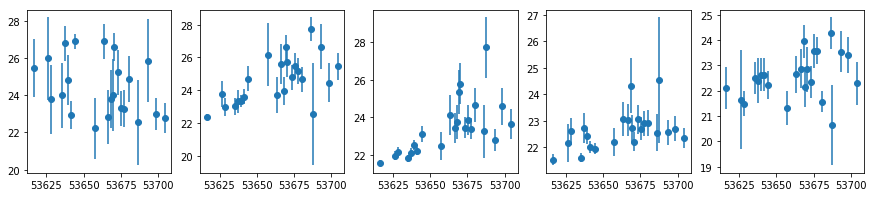

idx,FLAG,MJD,FILT,MAG,MERR,MSKYERR,MGALERR,FLUX,FLUXERR,SKYERR,GALERR,NPRE,TELE,RUN,STRIP,IDCCD
0,288,53616.392467,1,22.334,0.183,0.239,0.0,4.127,0.6938,0.916,0.0,22,sdss,5566,82N,2
1,288,53616.38915,2,21.607,0.147,0.125,0.0,8.201,1.097,0.9379,0.0,25,sdss,5566,82N,2
2,288,53616.389979,3,21.535,0.209,0.274,0.0,8.64,1.647,2.185,0.0,25,sdss,5566,82N,2
3,288,53616.391638,4,22.115,0.827,0.922,0.0,3.758,5.015,5.456,0.0,25,sdss,5566,82N,2
4,262,53616.390808,0,25.473,1.546,1.211,0.0,-0.8565,2.186,1.492,0.0,21,sdss,5566,82N,2
5,418,53626.369682,1,23.744,0.798,1.275,0.0,1.043,0.8279,1.431,0.0,22,sdss,5603,82N,2
6,290,53626.366365,2,21.975,0.223,0.236,0.0,5.828,1.186,1.272,0.0,25,sdss,5603,82N,2
7,292,53626.367194,3,22.163,0.724,1.222,0.0,4.785,2.911,5.521,0.0,25,sdss,5603,82N,2
8,1452,53626.368853,4,21.646,1.941,3.922,0.0,7.015,16.66,31.1,0.0,25,sdss,5603,82N,2
9,1422,53626.368023,0,25.991,2.222,3.78,0.0,-1.628,4.282,6.586,0.0,21,sdss,5603,82N,2


In [5]:
test_id = 932

# Get fit published values
published_values = sdss.master_table[sdss.master_table['CID'] == test_id]
x0 = published_values['x0SALT2zspec'][0]
x1 = published_values['x1SALT2zspec'][0]
c = published_values['cSALT2zspec'][0]
chisq_norm = published_values['chi2SALT2zspec'][0] / published_values['ndofSALT2zspec'][0]
peak_mjd = published_values['MJDatPeakrmag'][0]

print('Published Values for CID {}:'.format(test_id))
print('x0: ', x0)
print('x1: ', x1)
print('c: ', c)
print('chisq: ', published_values['chi2SALT2zspec'][0])
print('ndof: ', published_values['ndofSALT2zspec'][0])
print('chisq_norm: ', chisq_norm)

# Get sdss photometry data
phot_data = sdss.get_data_for_id(test_id)

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    band_data = phot_data[phot_data['FILT'] == i]
    axes[i].scatter(band_data['MJD'], band_data['MAG'])
    axes[i].errorbar(band_data['MJD'], band_data['MAG'], yerr=band_data['MERR'], linestyle='')

plt.show()

phot_data.show_in_notebook(display_length=10)


## Create an SNCosmo input table

In [6]:
@np.vectorize
def band_name(filt, idccd):
    """Return the sncosmo band name given filter and CCD id
    
    Args:
        filt  (str): Filter name <ugriz>
        idccd (int): Column number 1 through 6
    
    Args:
        The name of the filter registered with sncosmo
    """

    return 'doi_2010_{}{}'.format('ugriz'[filt], idccd)


In [7]:
input_table = Table()

input_table.meta = phot_data.meta
input_table['flag'] = phot_data['FLAG']
input_table['time'] = phot_data['MJD']
input_table['band'] = band_name(phot_data['FILT'], phot_data['IDCCD'])
input_table['zp'] = np.full(len(phot_data), 2.5 * np.log10(3631))
input_table['flux'] = phot_data['FLUX'] #* 1E-6
input_table['fluxerr'] = phot_data['FLUXERR'] #* 1E-6
input_table['zpsys'] = np.full(len(phot_data), 'ab')

# Apply cuts described in Sako et al.
input_table = input_table[input_table['flag'] < 1024]
input_table = input_table[input_table['time'] < peak_mjd + 45]
input_table = input_table[input_table['time'] > peak_mjd - 15]

if test_id in outliers:
    print('Wait you need to remove the outier data points!!!!!')

input_table.show_in_notebook(display_length=10)


idx,flag,time,band,zp,flux,fluxerr,zpsys
0,288,53616.392467,doi_2010_g2,8.90006562228223,4.127,0.6938,ab
1,288,53616.38915,doi_2010_r2,8.90006562228223,8.201,1.097,ab
2,288,53616.389979,doi_2010_i2,8.90006562228223,8.64,1.647,ab
3,288,53616.391638,doi_2010_z2,8.90006562228223,3.758,5.015,ab
4,262,53616.390808,doi_2010_u2,8.90006562228223,-0.8565,2.186,ab
5,418,53626.369682,doi_2010_g2,8.90006562228223,1.043,0.8279,ab
6,290,53626.366365,doi_2010_r2,8.90006562228223,5.828,1.186,ab
7,292,53626.367194,doi_2010_i2,8.90006562228223,4.785,2.911,ab
8,289,53628.354366,doi_2010_g2,8.90006562228223,2.278,1.12,ab
9,289,53628.351048,doi_2010_r2,8.90006562228223,4.813,1.207,ab


## Run fit



Fitting for all terms except z:


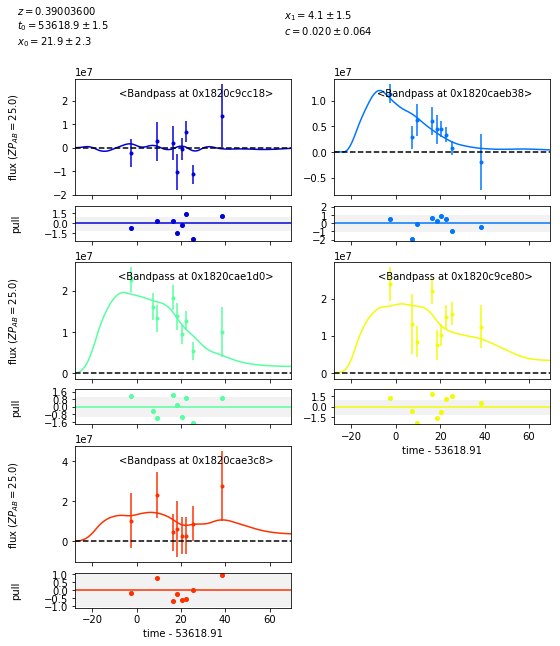

      success: True
      message: 'Minimization exited successfully.'
        ncall: 110
        chisq: 49.335116375868964
         ndof: 39
  param_names: ['z', 't0', 'x0', 'x1', 'c']
   parameters: array([3.90036000e-01, 5.36189090e+04, 2.18822343e+01, 4.08788955e+00,
       2.03723440e-02])
 vparam_names: ['t0', 'x0', 'x1', 'c']
   covariance: array([[ 2.14328460e+00, -1.14862121e+00, -3.37027721e-01,
         9.22378715e-03],
       [-1.14862121e+00,  5.14483031e+00, -2.52169249e+00,
        -4.64979878e-02],
       [-3.37027721e-01, -2.52169249e+00,  2.27368873e+00,
         2.75952083e-02],
       [ 9.22378715e-03, -4.64979878e-02,  2.75952083e-02,
         4.04905283e-03]])
       errors: OrderedDict([('t0', 1.4638865115593944), ('x0', 2.26822183984302), ('x1', 1.5078755696514883), ('c', 0.06363216820081755)])
         nfit: 1
    data_mask: array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True

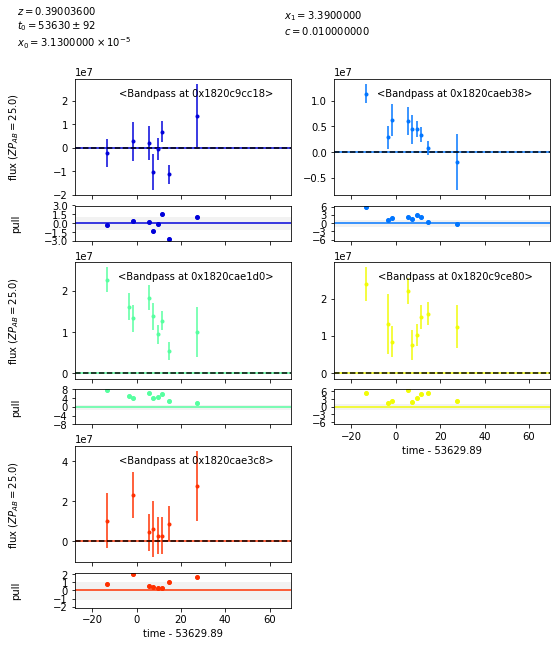

      success: True
      message: 'Minimization exited successfully.'
        ncall: 28
        chisq: 438.52089615138374
         ndof: 42
  param_names: ['z', 't0', 'x0', 'x1', 'c']
   parameters: array([3.90036000e-01, 5.36298925e+04, 3.13000000e-05, 3.39000000e+00,
       1.00000000e-02])
 vparam_names: ['t0']
   covariance: array([[524481.00576138]])
       errors: OrderedDict([('t0', 92.45304953802406)])
         nfit: 1
    data_mask: array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])
    chi2_norm: 10.440973717890088






In [8]:
print('\n\nFitting for all terms except z:')
source = sncosmo.get_source('salt2', version='2.0')
model = sncosmo.Model(source=source)
model.set(z=input_table.meta['redshift'])

result, fitted_model = sncosmo.fit_lc(input_table, model, ['t0', 'x0', 'x1', 'c'], bounds=None)
result['chi2_norm'] = (result.chisq / result.ndof)
sncosmo.plot_lc(input_table, model=fitted_model, errors=result.errors)
plt.show()
print(result)

print('\n\nFitting with fixed, published values:')
model.set(z=input_table.meta['redshift'], x0=x0, x1=x1, c=c)
result, fitted_model = sncosmo.fit_lc(input_table, model, ['t0'], bounds=None)
result['chi2_norm'] = (result.chisq / result.ndof)
sncosmo.plot_lc(input_table, model=fitted_model, errors=result.errors)
plt.show()
print(result)
print('\n\n\n')
